In [1]:
import os, random
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# On the kaggle notebook

# we only take the first 2000 from the training set

# and only the first 1000 from the test set

# REMOVE [0:2000] and [0:1000] when running locally

NumTrain = 10000

TRAIN_DIR = '../Train/train/'

TEST_DIR = 'input/test'

train_image_file_names = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)][0:NumTrain] 

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)][(NumTrain*9/10):NumTrain]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:(NumTrain/2)] + train_cats[:(NumTrain/2)]
random.shuffle(train_images)
#test_images =  test_images[:25]

In [3]:
# Slow, yet simple implementation with tensorflow
# could be rewritten to be much faster

def decode_image(image_file_names, resize_func=None):

    images = []

    graph = tf.Graph()
    with graph.as_default():
        file_name = tf.placeholder(dtype=tf.string)
        file = tf.read_file(file_name)
        image = tf.image.decode_jpeg(file)
        if resize_func != None:
            image = resize_func(image)

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()   
        for i in tqdm(range(len(image_file_names))):
            images.append(session.run(image, feed_dict={file_name: image_file_names[i]}))
            if (i+1) % 1000 == 0:
                print('Images processed: ',i+1)

        session.close()

    return images


# Set resize function and generate image data from filenames

Note that this crops the images by using the resize function below

In [6]:
HEIGHT = 256
WIDTH = 256

resize_func = lambda image: tf.image.resize_image_with_crop_or_pad(image, HEIGHT, WIDTH)
#resize_func = lambda image: tf.image.resize_images(image, (HEIGHT, WIDTH), method = 0)
#resize_func = lambda image: tf.image.resize_area(image, (HEIGHT, WIDTH))

In [7]:
train = decode_image(train_images, resize_func=resize_func)
test = decode_image(test_images, resize_func=resize_func)

 10%|█         | 1029/10000 [00:05<00:49, 180.70it/s]

('Images processed: ', 1000)


 20%|██        | 2018/10000 [00:11<00:44, 177.59it/s]

('Images processed: ', 2000)


 30%|███       | 3020/10000 [00:17<00:38, 179.69it/s]

('Images processed: ', 3000)


 40%|████      | 4020/10000 [00:22<00:32, 181.47it/s]

('Images processed: ', 4000)


 50%|█████     | 5020/10000 [00:28<00:27, 178.43it/s]

('Images processed: ', 5000)


 60%|██████    | 6027/10000 [00:34<00:23, 170.99it/s]

('Images processed: ', 6000)


 70%|███████   | 7026/10000 [00:39<00:16, 179.88it/s]

('Images processed: ', 7000)


 80%|████████  | 8031/10000 [00:45<00:11, 174.06it/s]

('Images processed: ', 8000)


 90%|█████████ | 9033/10000 [00:51<00:05, 175.82it/s]

('Images processed: ', 9000)


100%|██████████| 10000/10000 [00:56<00:00, 176.12it/s]


('Images processed: ', 10000)


100%|██████████| 1000/1000 [00:05<00:00, 172.39it/s]

('Images processed: ', 1000)


## Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced.

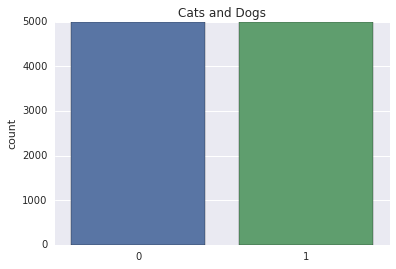

In [8]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

# Get some cats and dogs for samples

In [9]:
cats = decode_image(train_cats[:1000], resize_func=resize_func)
dogs = decode_image(train_dogs[:1000], resize_func=resize_func)

100%|██████████| 1000/1000 [00:05<00:00, 181.13it/s]


('Images processed: ', 1000)


100%|██████████| 1000/1000 [00:05<00:00, 176.75it/s]

('Images processed: ', 1000)


In [10]:
np.shape(dogs[0])

(256, 256, 3)

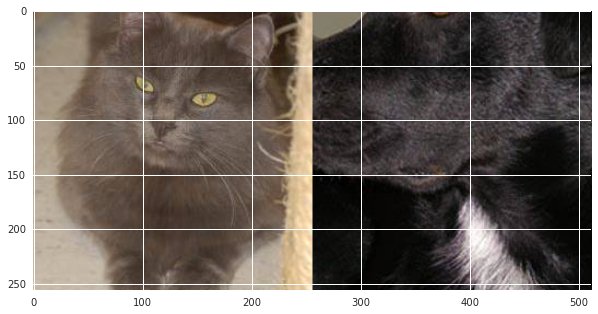

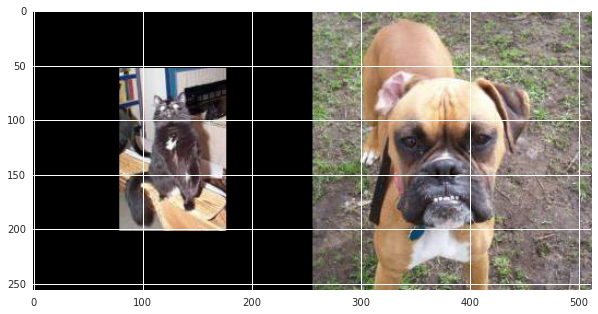

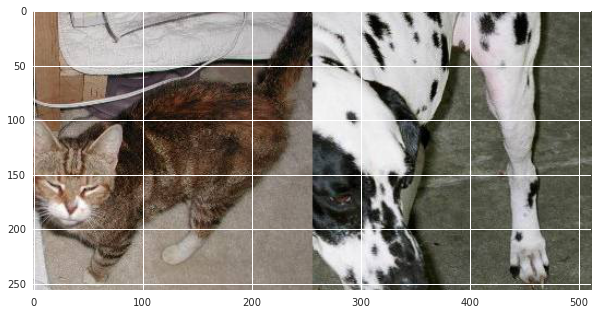

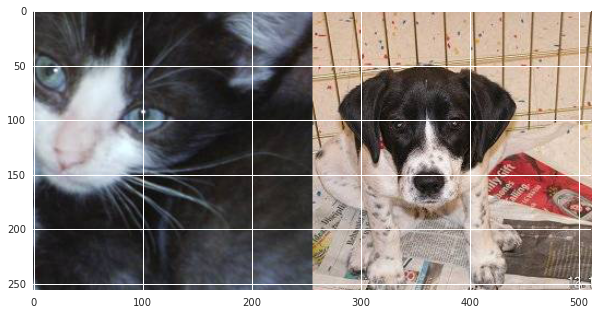

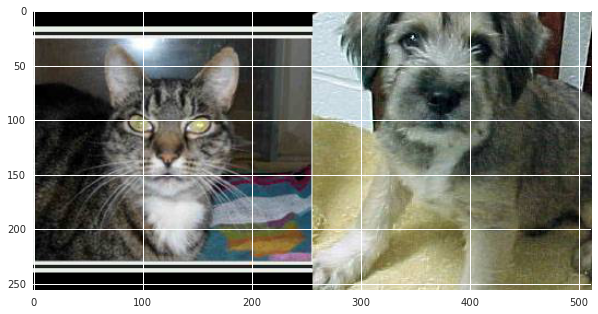

In [11]:
def show_cats_and_dogs(idx):
    cat = cats[idx]
    dog = dogs[idx]
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

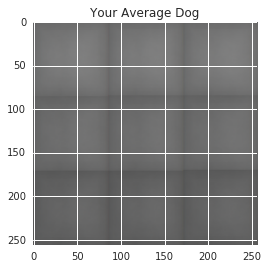

In [12]:
dog_avg = np.array([dog.T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg.reshape(WIDTH, HEIGHT,3).astype(np.uint8))
plt.title('Your Average Dog')

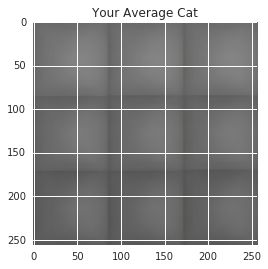

In [13]:
cat_avg = np.array([cat.T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg.reshape(WIDTH, HEIGHT,3).astype(np.uint8))
plt.title('Your Average Cat')

# Now set the size, use this to generate resized images.

In [14]:
WIDTH=128
HEIGHT=128

In [15]:
def getResizedAndCroppedImages(image_file_names, resize_func=None):
    images = []
    
    graph = tf.Graph()
    with graph.as_default():
        file_name = tf.placeholder(dtype=tf.string)
        file = tf.read_file(file_name)
        image = tf.image.decode_jpeg(file)
        #w,h,c = np.shape(image.eval())
        new_images = []
        new_images.append(image)
        new_image = tf.image.resize_images(new_images, (WIDTH, HEIGHT), method = 0)[0]
        #scipy.misc.imresize(image,np.min([WIDTH*1.0 / w, HEIGHT*1.0 / h ]))
    
    sess = tf.Session()

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()   
        for i in tqdm(range(len(image_file_names))):
            image = session.run(new_image, feed_dict={file_name: image_file_names[i]})
            #new_image = scipy.misc.imresize(image,np.min([WIDTH*1.0 / np.shape(image)[0], HEIGHT*1.0 / np.shape(image)[1] ]))
            images.append(image)
            
            if (i+1) % 1000 == 0:
                print('Images processed: ',i+1)

        session.close()

    return [image.astype(np.uint8) for image in images]



In [16]:
train = getResizedAndCroppedImages(train_images, resize_func=None)
test = getResizedAndCroppedImages(test_images, resize_func=None)

 10%|█         | 1027/10000 [00:04<00:35, 254.34it/s]

('Images processed: ', 1000)


 20%|██        | 2043/10000 [00:08<00:31, 255.85it/s]

('Images processed: ', 2000)


 30%|███       | 3044/10000 [00:12<00:28, 247.95it/s]

('Images processed: ', 3000)


 40%|████      | 4038/10000 [00:16<00:23, 253.40it/s]

('Images processed: ', 4000)


 50%|█████     | 5036/10000 [00:20<00:18, 261.97it/s]

('Images processed: ', 5000)


 60%|██████    | 6027/10000 [00:23<00:15, 248.95it/s]

('Images processed: ', 6000)


 70%|███████   | 7028/10000 [00:27<00:11, 251.04it/s]

('Images processed: ', 7000)


 80%|████████  | 8031/10000 [00:31<00:07, 254.29it/s]

('Images processed: ', 8000)


 90%|█████████ | 9026/10000 [00:35<00:03, 254.07it/s]

('Images processed: ', 9000)


100%|██████████| 10000/10000 [00:39<00:00, 250.93it/s]


('Images processed: ', 10000)


100%|██████████| 1000/1000 [00:03<00:00, 251.14it/s]


('Images processed: ', 1000)


In [17]:
#finalTrain = getResizedAndCroppedImages(train, WIDTH, HEIGHT)
cats = getResizedAndCroppedImages(train_cats[:100], resize_func=resize_func)

100%|██████████| 100/100 [00:00<00:00, 251.30it/s]


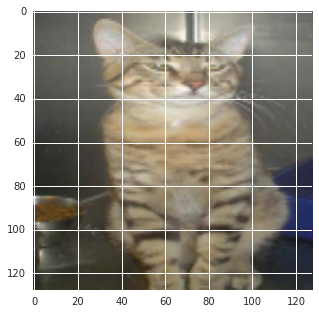

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(cats[36])
plt.show()

In [19]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=[WIDTH, HEIGHT, 3], activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])




In [20]:
nb_epoch = 20
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        

#predictions, history = run_catdog()

In [24]:
history = LossHistory()

train_x = [train[i] for i in range(NumTrain)]
train_x = np.array(train_x).astype(float)

test_x = [test[i] for i in range(len(test))]
test_x = np.array(test_x).astype(float)

In [25]:
model.fit(train_x, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.20, verbose=1, shuffle=True, callbacks=[history, early_stopping])

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 106s - loss: 0.6933 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.4895
Epoch 2/20
8000/8000 [==============================] - 99s - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6933 - val_acc: 0.4895
Epoch 3/20
8000/8000 [==============================] - 99s - loss: 0.6854 - acc: 0.5435 - val_loss: 0.6428 - val_acc: 0.6175
Epoch 4/20
8000/8000 [==============================] - 99s - loss: 0.6434 - acc: 0.6289 - val_loss: 0.5860 - val_acc: 0.6805
Epoch 5/20
8000/8000 [==============================] - 99s - loss: 0.6087 - acc: 0.6716 - val_loss: 0.5729 - val_acc: 0.6900
Epoch 6/20
8000/8000 [==============================] - 99s - loss: 0.5876 - acc: 0.6892 - val_loss: 0.5433 - val_acc: 0.7175
Epoch 7/20
8000/8000 [==============================] - 99s - loss: 0.5673 - acc: 0.7139 - val_loss: 0.5328 - val_acc: 0.7205
Epoch 8/20
8000/8000 [==============================] - 99s - loss: 0

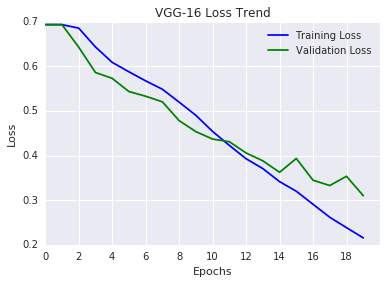

In [26]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [27]:
predictions = model.predict(test_x, verbose=0)

I am 77.01% sure this is a Cat


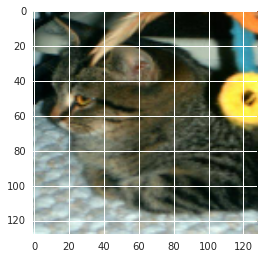

I am 76.70% sure this is a Dog


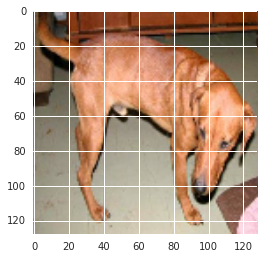

I am 99.90% sure this is a Dog


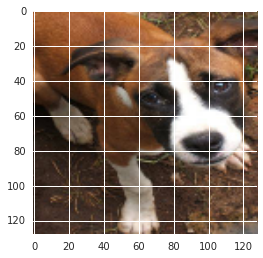

I am 90.74% sure this is a Dog


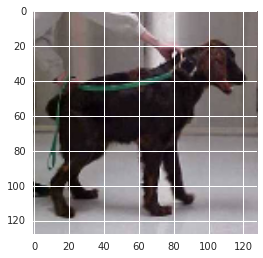

I am 99.49% sure this is a Dog


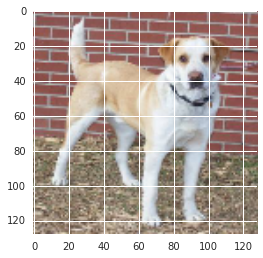

I am 99.77% sure this is a Dog


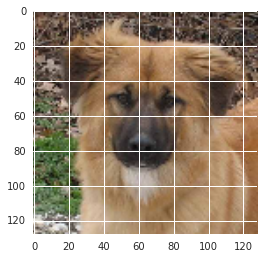

I am 92.39% sure this is a Cat


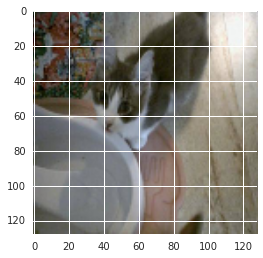

I am 98.09% sure this is a Dog


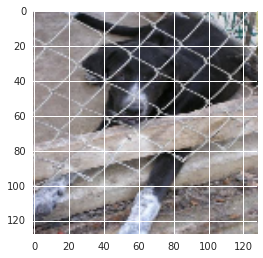

I am 95.89% sure this is a Dog


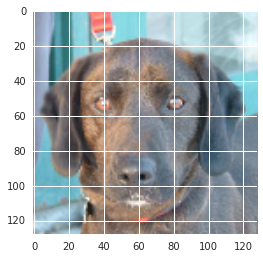

I am 98.94% sure this is a Dog


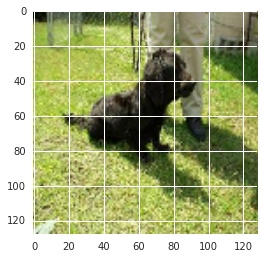

In [28]:
for i in range(10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [ ]:
np.shape(test[0])